In [1]:
import sys
sys.path.append('../utils/')
sys.path.append('../paviaUTools/')

import matplotlib.pyplot as plt
from datasetLoader import datasetLoader
import os
import numpy as np
from whole_pipeline import whole_pipeline_all, whole_pipeline_divided, whole_pipeline_divided_parallel
import torch
from plots import *
from weights_anal import *

import gc
torch.cuda.empty_cache()
gc.collect()

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
parent_dir = os.path.join(os.getcwd(),"..")
csv_path = os.path.join(parent_dir, 'datasets', 'paviaU.csv')
gt_path = os.path.join(parent_dir, 'datasets', 'paviaU_gt.csv')
# csv_path = os.path.join(parent_dir, 'datasets', 'pavia.csv')
# gt_path = os.path.join(parent_dir, 'datasets', 'pavia_gt.csv')

dsl = datasetLoader(csv_path, gt_path)

df = dsl.read_dataset(gt=False)
X = np.array(df)
X = X.reshape((610,340, 103))
# X = X.reshape((1096, 715, 102))

df = dsl.read_dataset(gt=True)
y = np.array(df)

factor = 11
rows_factor = factor
cols_factor = factor

X = torch.from_numpy(X)
y = torch.from_numpy(y)

X = X.to(device)
y = y.to(device)

torch.any(M==torch.nan) ?  tensor(False)


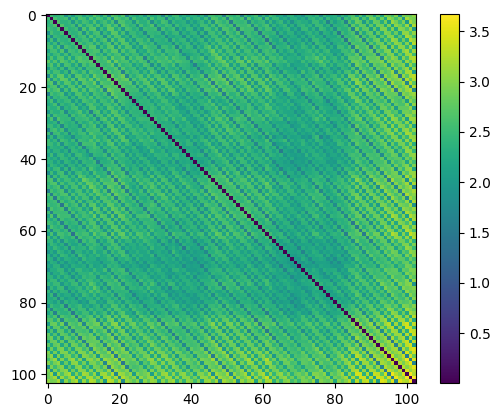

torch.any(M==torch.nan) ?  tensor(False)
torch.any(M==torch.nan) ?  tensor(False)


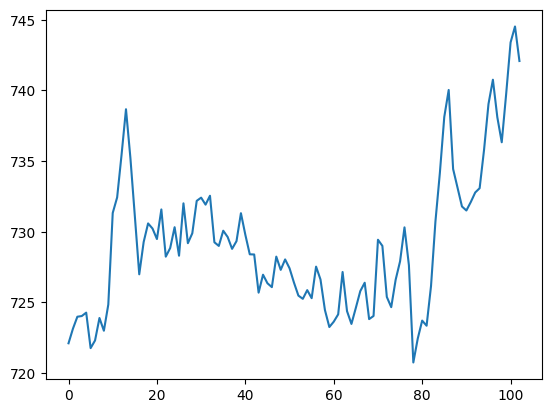

In [3]:
from MetaLearner import HDDOnBands

distances = HDDOnBands.run(X)

show_distances(distances)


weights, dist_batches = HDDOnBands.createL1WeightedBatches(X, normalize=False)

show_weights(weights, is_normalized=False)


# plot_tree(distances.cpu().numpy())

XXXXXXX IN METHOD XXXXXXXXX
WHOLE METHOD TIME:  0.07692813873291016
XXXXXXX IN CLASSIFICATION XXXXXXXXX
Train Accuracy:  0.8835606563049684
Test Accuracy:  0.5931324110671937


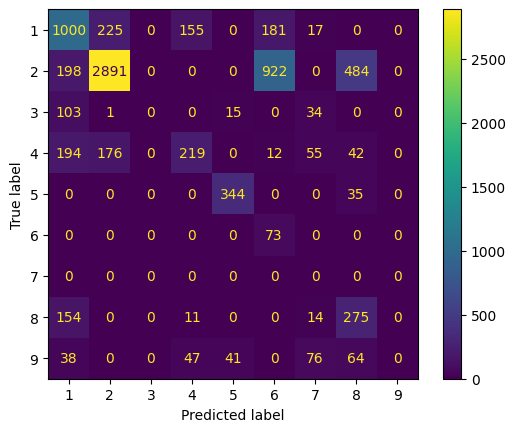

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

train_acc,test_acc, test_preds,test_gt = whole_pipeline_all(X,y, rows_factor, cols_factor, is_normalize_each_band=True, method_label_patch='most_common')

confusion_mat(test_gt,test_preds, range(1,10))


[W CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]


TOTAL TIME FOR METHOD:  2.824596881866455
Train Accuracy:  0.8892339544513458
Test Accuracy:  0.4553262688232013


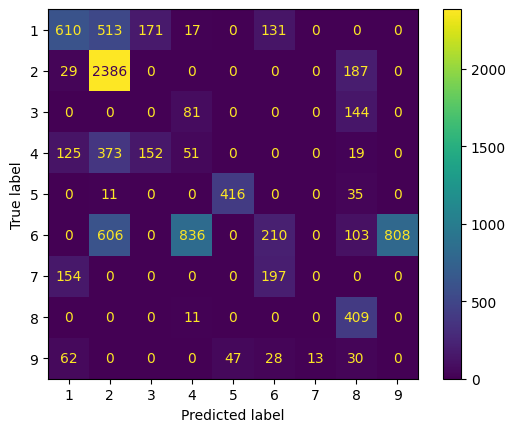

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

weights, dist_batches = HDDOnBands.createUniformWeightedBatches(X, clusters_amount=3)

# print(dist_batches[1])

# print(dist_batches)

train_acc,test_acc, test_preds,test_gt = whole_pipeline_divided_parallel(X,y, rows_factor, cols_factor, is_normalize_each_band=True, method_label_patch='most_common', weights=weights, distance_batches= dist_batches)

confusion_mat(test_gt,test_preds, range(1,10))
